# Mouse islets - Endocrine cell analyses

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy as sc
import pandas as pd
import seaborn as sns
import xlsxwriter
from matplotlib import rcParams
import gseapy as gp
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.8 umap==0.4.5 numpy==1.21.2 scipy==1.5.4 pandas==1.3.5 scikit-learn==0.22 statsmodels==0.13.2 python-igraph==0.8.0 louvain==0.7.0 leidenalg==0.7.0


In [2]:
sc.set_figure_params(frameon=False)

## Load data and preprocess data

Data was downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE128565

In [3]:
adata = sc.read('/data/GSE128565_adata_processed.h5ad.h5')

In [4]:
adata_raw = sc.read('/data/GSE128565_adata_raw.h5ad.h5')

In [7]:
adata_raw = adata_raw[adata.obs_names].copy()

In [9]:
adata_raw.obs = adata.obs

In [10]:
sc.pp.normalize_total(adata_raw, exclude_highly_expressed=True)
sc.pp.log1p(adata_raw)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Gcg', 'Chgb', 'Spata21', 'Try5', 'Ghrl', 'Iapp', 'Hbb-bs', 'Zg16', 'Ins2', 'Hba-a1', 'Hba-a2', 'Ppy', 'Pyy', 'Chga', 'Sst', 'Tff3', 'Ttr', 'Malat1', 'Ins1', 'mt-Nd1', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Cytb']
    finished (0:00:01)


In [14]:
mouse = adata_raw[adata_raw.obs.treatment.isin(['Ctrl'])].copy()

In [9]:
mouse.obs.groups_named_broad.value_counts()

beta            5664
alpha            783
delta            494
polyhormonal     418
PP                70
Name: groups_named_broad, dtype: int64

In [37]:
mouse = mouse[mouse.obs.groups_named_broad.isin(['beta', 'alpha', 'delta', 'PP'])].copy()

In [38]:
for i in ['groups_named_broad_colors', 'groups_named_fine_colors', 'groups_named_beta_dpt_colors', 'proliferation_man_colors']:
    mouse.uns[i] = adata.uns[i]

## Manifold and clustering

In [68]:
sc.pp.highly_variable_genes(mouse, n_top_genes=4000)
sc.pp.pca(mouse)
sc.pp.neighbors(mouse)
sc.tl.umap(mouse)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


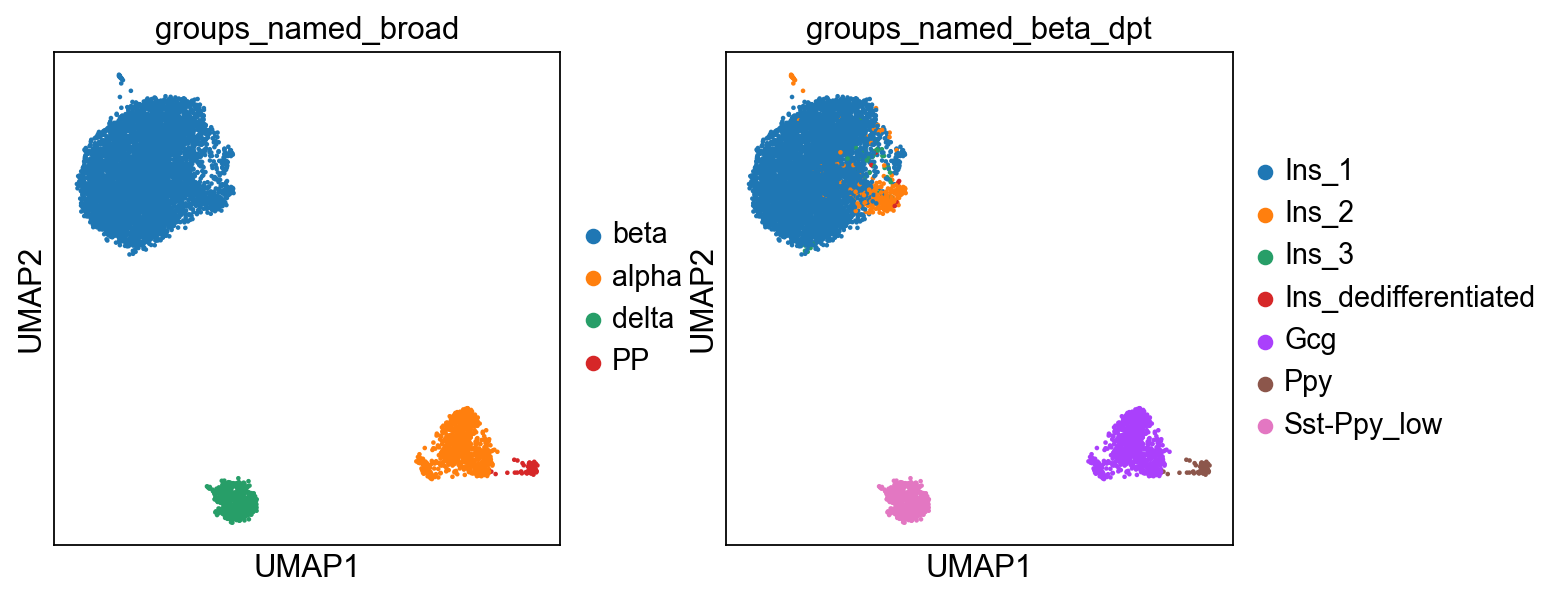

In [70]:
sc.pl.umap(mouse, color=['groups_named_broad', 'groups_named_beta_dpt'])

In [71]:
sc.tl.louvain(mouse, resolution=0.7)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


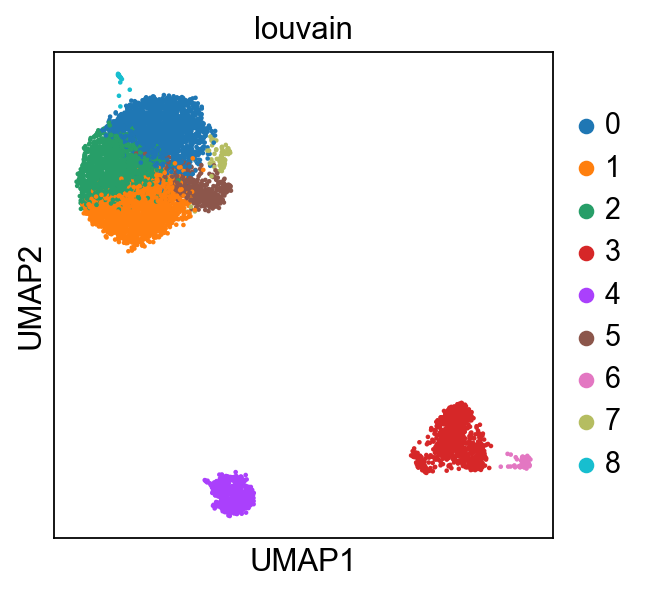

In [72]:
sc.pl.umap(mouse, color='louvain')

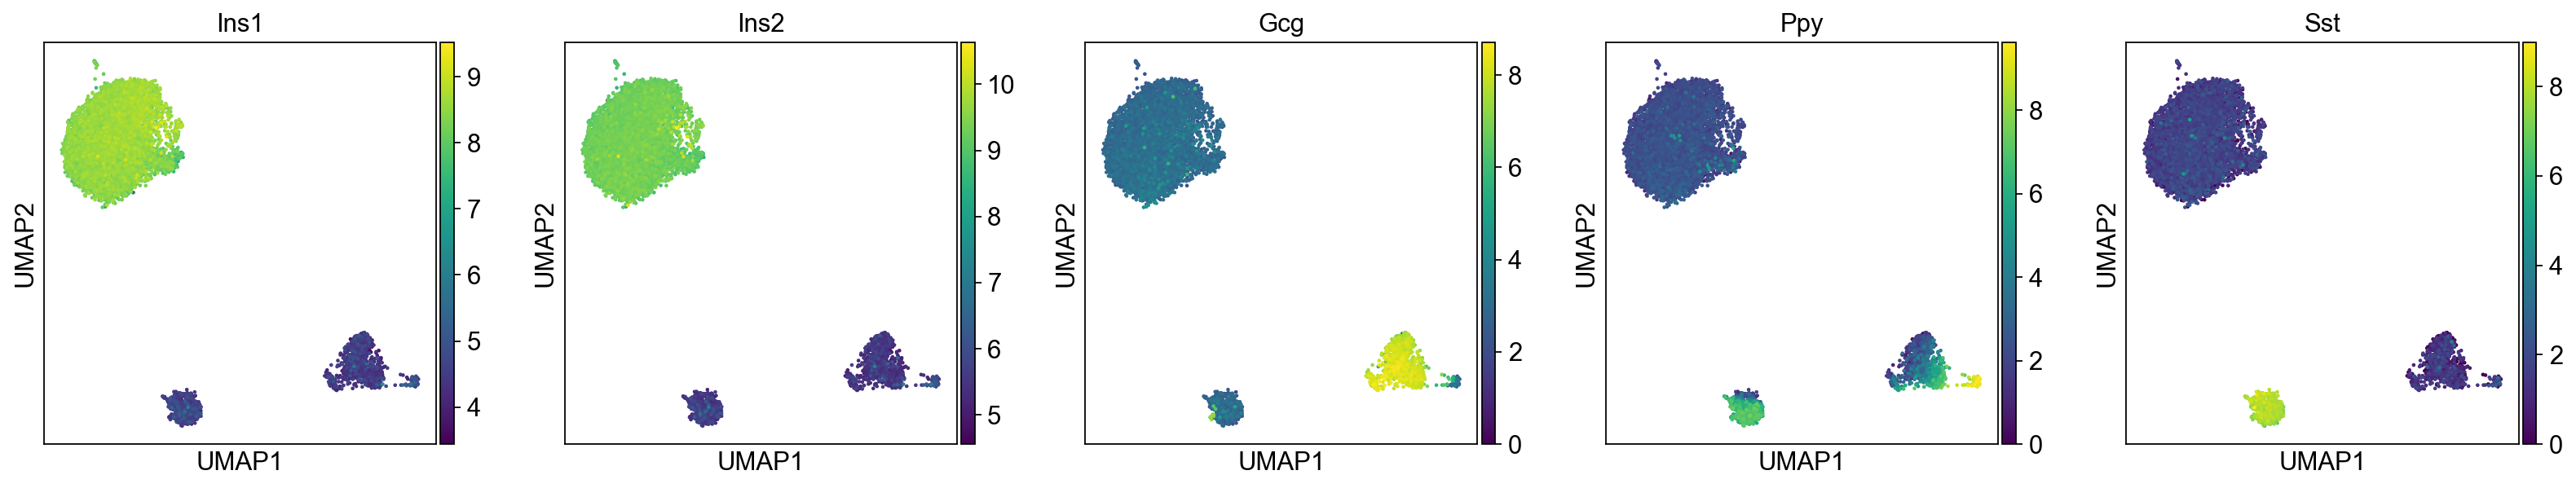

In [73]:
sc.pl.umap(mouse, color=['Ins1', 'Ins2', 'Gcg', 'Ppy', 'Sst'], ncols=5)

In [76]:
map_names = {}
for c in mouse.obs['louvain'].cat.categories:
    if c in ['0', '1', '2', '5', '7', '8']:
        map_names[c] = 'beta'        
    elif c in ['3']:
        map_names[c] = 'alpha' 
    elif c in ['4']:
        map_names[c] = 'delta'
    elif c in ['6']:
        map_names[c] = 'PP'    

mouse.obs['louvain_anno_broad'] = mouse.obs['louvain']
mouse.obs['louvain_anno_broad'] = mouse.obs['louvain_anno_broad'].map(map_names).astype('category')

In [77]:
mouse.obs['louvain_anno_broad'] = mouse.obs['louvain_anno_broad'].cat.reorder_categories(['alpha', 'beta', 'delta', 'PP'])
mouse.uns['louvain_anno_broad_colors'] = ['#33a02c', '#e31a1c', '#1f78b4', '#b15928']

In [8]:
sc.set_figure_params(frameon=False)

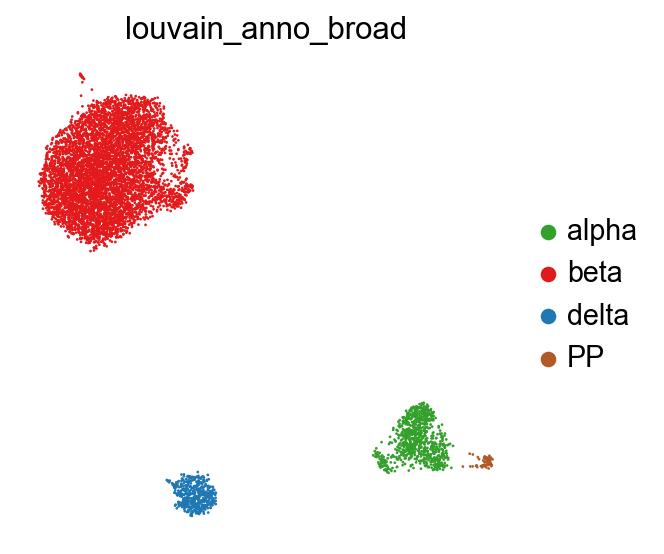

In [9]:
sc.pl.umap(adata, color='louvain_anno_broad', size=6)

### save adata

In [79]:
sc.write('../data/mouse_all.h5ad', mouse)

In [12]:
adata

AnnData object with n_obs × n_vars = 7011 × 18210
    obs: 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'groups', 'treatment', 'groups_named_broad', 'S_score', 'G2M_score', 'phase', 'proliferation', 'proliferation_man', 'doublet_score', 'groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst', 'groups_named_broad_cond', 'louvain', 'louvain_r', 'louvain_anno_broad'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'groups_named_beta_dpt_colors', 'groups_named_broad_colors', 'louvain', 'louvain_anno_broad_colors', 'louvain_colors', 'neighbors', 'pca', 'proliferation_man_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Composition

In [11]:
adata.obs[['n_counts', 'n_genes']].median()

n_counts    16927.0
n_genes      2423.0
dtype: float64

findfont: Font family ['Helvetica Light'] not found. Falling back to DejaVu Sans.


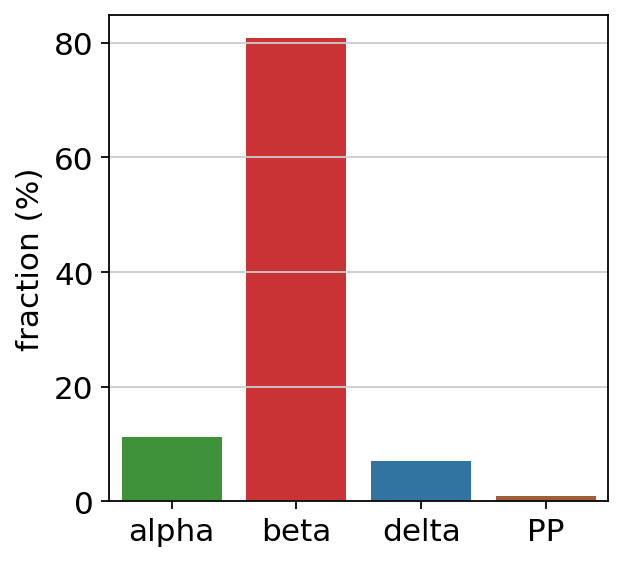

In [13]:
df=adata.obs[['louvain_anno_broad']]
order_cat=['alpha', 'beta', 'delta', 'PP']
pl.subplots()
x='louvain_anno_broad'
y='proportion'
prop_df = (df[x]
            .value_counts(normalize=True)
            .rename(y)
            .reset_index())

prop_df[y]=prop_df[y]*100

sns.barplot(x='index', y=y, data=prop_df,palette=adata.uns['louvain_anno_broad_colors'],order=order_cat,orient='v')
pl.xticks(rotation=0,fontsize=14,fontname='Helvetica Light')
pl.yticks(rotation=0,fontsize=14,fontname='Helvetica Light')

pl.xlabel('')
pl.ylabel('fraction (%)',fontsize=14,fontname='Helvetica Light')
#pl.tight_layout()
#pl.legend('')
#pl.savefig('/Users/sophie/Documents/ICB/Projects/2020_10X_specied_comparison/human_islets/figures/endocrine_proportion.pdf',dpi=300)
pl.show()

## Cell type marker expression

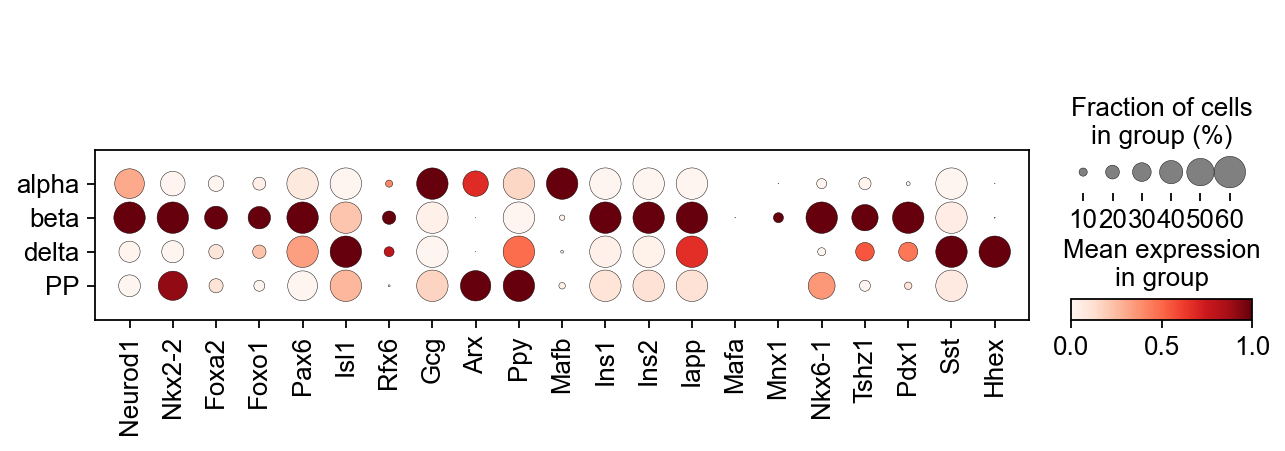

In [50]:
genes=['Neurod1', 'Nkx2-2', 'Foxa2', 'Foxo1', 'Pax6', 'Isl1', 'Rfx6', 'Gcg', 'Arx', 'Ppy',
       'Mafb', 'Ins1', 'Ins2', 'Iapp',  'Mafa', 'Mnx1', 'Nkx6-1', 'Tshz1', 'Pdx1',  'Sst', 'Hhex']
sc.pl.dotplot(adata, groupby='louvain_anno_broad', var_names=genes, standard_scale='var', dot_max=0.6)

## Endocrine enriched marker identification

In [33]:
marker_dict_endo=dict()
for group in ['alpha', 'beta', 'delta', 'PP']:
    
    
    refs = ['alpha', 'beta', 'delta', 'PP']
    refs.remove(group)
    # subset to genes expressed in >20% of celltype
    adata_group = adata[adata.obs.louvain_anno_broad.isin([group])].copy()
    
    genes_frac = (adata_group.X > 0).sum(0) / adata_group.n_obs
    if group in ['PP']:
        genes = adata_group.var_names[genes_frac.A1>0.05]
    else:
        genes = adata_group.var_names[genes_frac.A1>0.05]
    
    adata_sub=adata[:,genes].copy()
    
    sc.tl.rank_genes_groups(adata_sub,groupby='louvain_anno_broad',method='t-test',n_genes=adata_sub.n_vars)
    df = sc.get.rank_genes_groups_df(adata_sub, group=group).loc[sc.get.rank_genes_groups_df(adata_sub, group=group)['logfoldchanges']>0.5]
    genes = df['names']
    marker_dict_endo[group]=list(genes)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

In [34]:
workbook = xlsxwriter.Workbook('./output_files/marker_dict_endo_enriched.xlsx')

worksheet = workbook.add_worksheet()

row = 0
col = 0

for key in marker_dict_endo.keys():
    row = 0
    worksheet.write(row, col, key)
    for item in marker_dict_endo[key]:
        worksheet.write(row+1, col, item)
        row += 1
    col += 1
workbook.close()